# Stochastic Volatility - Notebook
<!-- Author: RJ Dance -->
<!--sent 16/6 to CB, YB -->
<!--updated 24/6  -->

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Table of contents
* [Introduction](#Introduction)
* [Geometric Brownian Motion](#Geometric-Brownian-Motion)
* [Checking Implementation for GBm](#Checking-Implementation-for-GBm)
    * [Effect of coarse/fine dt](#em-gbm-coarse-fine)
    * [GBm by Milstein Method](#milstein-gbm)
    * [OU by Euler](#euler-ou)
    * [OU after a nightmare](#ou-theory)
* [CKLS Model](#CKLS-Model)
* [Maximum Likelihood Estimation](#Maximum-Likelihood-Estimation)
* [Convergence](#Convergence)
* [Heston](#Heston)
* [SABR](#SABR-Model)

<!-- Examples so i can remember how to number things... -->
<!-- * [2. Scottish infrastructure as a whole](#2.-Scottish-infrastructure-as-a-whole) -->
<!--     * [2.1 Summary maps of Scotland](#2.1-Summary-maps-of-Scotland) -->

## Introduction
* [Table of contents](#Table-of-contents)

Ths project focuses on parameter estimation methodologies within 

## Geometric Brownian Motion
* [Table of contents](#Table-of-contents)

Starting with simulating an SDE of the form of Geometric Brownian Motion:
$$
dX(t) = \mu X(t) dt + \sigma X(t)dW(t)
$$
where $\mu\:(t,X_t) = \mu X_t$ and $\sigma \:(t,X_t) = \sigma X_t$ are the drift and diffusion functions respectively. By applying the Ito formula to $\ln X_t$, we obtain an expression for the dynamics, and integrate to give the explicit solution for $X_t$ (see Appendix A):
$$
X(t)=X(0)\exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W(t)\right)
$$
We start to simulate the integrals given here in differential form, by discretising the time into an evenly spaced mesh/grid on interval $[0,T]$ into N intervals like so:
$0 = t_0 < t_1 < \cdots < t_N = T$
so the change in time between these discrete points as dt (a.k.a. $h$).

#### Appendix A - Geometric Brownian Motion

Starting with our SDE of the form
$$
\label{eq:BSmodel}
dX(t) = \mu X_t dt + \sigma X_t dW_t
$$
where $W_t \sim N(0,t)$, $\mu$ and $\sigma \gt 0$ are constants. Given that the general Ito formula as:
$$
\label{eq:ito}
d(f(X_t)) = \frac{\partial f(X_t)}{\partial t}dt + \frac{\partial f(X_t) }{\partial X_t}dX_t + \frac{1}{2} \frac{\partial ^2}{\partial X_t^2}dX_t dX_t
$$
where here, we have $f(X_t) = \ln X_t$ such that
$$
d(\ln X_t) = 0 + \frac{1}{X_t}dX_t - \frac{1}{2} \frac{1}{X_t^2}dX_t dX_t
$$
substituting in for $dX_t$, and utilising the identities $dW_t dt = dt dt = 0$ and $dW_t dW_t = dt$,
$$
d(\ln X_t) = 0 + \frac{1}{X_t}[\mu X(t) dt + \sigma X(t)dW(t)] - \frac{1}{2} \frac{1}{X_t^2}[\mu X(t) dt + \sigma X(t)dW(t)]^2 \\
= \mu dt + \sigma dW_t - \frac{1}{2}\sigma^2 dt \\
= (\mu - \frac{\sigma^2}{2})dt + \sigma dW_t
$$
Integrating and solving for $X_t$:
$$
\int_0^T d(\ln X_t) = \int_0^T (\mu - \frac{\sigma^2}{2})dt + \int_0^T \sigma dW_t \\
\ln X_T - \ln X_0 = \ln \bigg( \frac{X_T}{X_0} \bigg) = \big(\mu - \frac{\sigma^2}{2}\big)T + \sigma W_T \\
X_T = X_0\; e^{\;(\mu - \frac{\sigma^2}{2})T + \sigma W_T}
$$
which can also be written as
$$
X_T = e^{\;\ln X_0 + (\mu - \frac{\sigma^2}{2})T + \sigma W_T}
$$
In order to simulate this process we require the distribution of this process, which is calculated by finding the mean and variance. We do this using the following tools:

 - If $Z \sim N(0,1)$, then $Y = e^Z \sim lognormal(\mu,\sigma^2)$, i.e. the log of Y is normal. Therefore, 
$$
Z = ln X_0 + (\mu - \frac{\sigma^2}{2})T + \sigma W_T \sim N(ln X_0 + (\mu - \frac{\sigma^2}{2})T, \sigma^2 T)
$$
and,
$$
X_T = e^Z \sim lognormal(ln X_0 + (\mu - \frac{\sigma^2}{2})T, \sigma^2 T)
$$
 - If $Z \sim N(0,1)$, the moment generating function 
$$
\mathbb{E}[e^{t(a+bZ)}] = e^{at} \mathbb{E}e^{tbZ} = e^{ at + \frac{(tb)^2}{2}}
$$
which by inspection is equivalent to $\mathbb{E}[e^Y] = e^{\mathbb{E}[Y] + \frac{1}{2}var[Y]}$, where $Y \sim N(at, b^2 t^2)$

So for our mean and variance of our geometric brownian motion gives us that for 
$$
X_T = e^{\;\ln X_0 + (\mu - \frac{\sigma^2}{2})T + \sigma W_T} = e^Y
$$
and therefore $Y \sim N(ln X_0 + (\mu - \frac{\sigma^2}{2})T, \sigma^2 T)$ as if Y is normal, $X_t = e^Y$ is lognormal and we know that,

$$
\mathbb{E}[X_T] = \mathbb{E}[e^Y] = e^{ln X_0 + (\mu - \frac{\sigma^2}{2})T + \frac{1}{2}\sigma^2 T} \\
= X_0 e^{\mu T}
$$
by expanding the exponential term in T and cancelling, the mean is shown. For the variance, we utilise the standard formula and the mean previously computed,
$$
\mathbb{E}[X_T^2] = \mathbb{E}[e^{2Y}] = e^ { \mathbb{E}[2Y] + \frac{1}{2}var[Y] }\\
= e^{2(\ln X_0 + (\mu - \frac{\sigma^2}{2})T) + 2\sigma^2 T}\\
= e^{2\ln X_0 + 2\mu T - \sigma^2 T + 2\sigma^2 T}\\
= e^{2\ln X_0 + 2\mu T + \sigma^2 T} = X_0^2\;e^{2\mu T + \sigma^2 T}
$$
finally giving,
$$
var[X_T] = \mathbb{E}[X_T^2] - \mathbb{E}[X_T]^2 \\
= X_0^2 e^{2\mu T + \sigma^2 T} - X_0^2 e^{2\mu T} \\
= X_0^2 e^{2\mu T}(e^{\sigma^2 T} - 1)
$$
for the variance. As a stochastic process as used here is inherently defined as a series of random variables we must consider the covariance arising.
 <span style='color:red'> Does $X_S$ and $X_T$ here mean the same process at two diferent times? Does this mean that we have the covariance of our collection of RV'S?? Im not sure!! </span> As our covariance formula contains the term $\mathbb{E}[X_T,X_S]$ we will compute this first.
$$
\mathbb{E}[X_T,X_S] = \mathbb{E}[X_0 e^{(\mu - \frac{\sigma^2}{2})T + \sigma W_T}. X_0 e^{(\mu - \frac{\sigma^2}{2})S + \sigma W_S}]\\
=X_0^2 e^{(\mu - \frac{\sigma^2}{2})(T+S)} \mathbb{E}[e^{\sigma W_T + \sigma W_S}]\\
=X_0^2 e^{\mu(T+S)-\frac{\sigma^2 T}{2} - \frac{\sigma^2 S}{2}}\mathbb{E}[e^{\sigma W_T + \sigma W_S}]\\
=X_0^2 e^{\mu(T+S) - \frac{\sigma^2}{2}(T-S)}\\
=X_0^2 e^{\mu(T+S) + 2\sigma^2 S}
$$

The $\mathbb{E}[e^{\sigma W_T + \sigma W_S}]$ term requires some further expansion, first apply the '+-' trick:
$$
\mathbb{E}[e^{\sigma W_T + \sigma W_S}] = \mathbb{E}[e^{\sigma(W_T + W_S - W_S) + \sigma W_S}] \\
= \mathbb{E}[e^{\sigma(W_T - W_S) + 2\sigma W_S}]\\
= \mathbb{E}[e^{\sigma(W_T - W_S)}]\mathbb{E}[e^{2\sigma W_S}]\\
$$
where each of the parts containing $e^{2\sigma W_S}$ and $e^{\sigma(W_T + - W_S)}$ are further broken down as below,
$$
\mathbb{E}[e^{2\sigma W_S}] = e^{\mathbb{E}[2\sigma W_S] + \frac{1}{2}var[2\sigma W_S]}\\
= e^{0+ \frac{1}{2}2^2 \sigma^2 S} = e^{2\sigma^2 S}
$$
$$
\mathbb{E}[e^{\sigma(W_T - W_S)}] = e^{\mathbb{E}[\sigma(W_T-W_S)] + \frac{1}{2}var[\sigma(W_T-W_S)]}\\
= e^{0+\frac{1}{2}\sigma^2 (T-S)} = e^{\frac{1}{2}\sigma^2 (T-S)}
$$
and each of these is substituted as follows
$$
\mathbb{E}[e^{\sigma W_T + \sigma W_S}] = e^{2\sigma^2 S} + e^{\frac{1}{2}\sigma^2 (T-S)}
$$
which allows for the final lines of the expression $\mathbb{E}[X_T,X_S]$, where terms cancel leaving only
$$
\mathbb{E}[X_T,X_S] = X_0^2 e^{\mu(T+S) + 2\sigma^2 S}
$$
as stated above. Then we can finally substitute into the covariance formula simply,
$$
cov(X_T,X_S) = \mathbb{E}[X_T,X_S]-\mathbb{E}[X_T]\mathbb{E}[X_S]\\
= \mathbb{E}[X_T,X_S] - X_0 e^{\mu T} X_0 e^{\mu S}\\
= X_0^2 e^{\mu(T+S) + 2\sigma^2 S} - X_0 e^{\mu T+S}\\
= X_0^2 e^{\mu(T+S)} \big( e^{2\sigma^2 S} -1 \big)
$$
as the final expression for the covariance.  <span style='color:red'> There is an error here, there should not be a 2 in front of the exponential power in the parenthesis!!! HELP! I have this in handwritten form which is far easier to look at... </span>

For the probability distrubution, for a regular normally distributed random variable $Z \sim N(\mu, \sigma^2)$ we have,
$$
f_Z(z) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(Z-\mu)^2}{2\sigma^2}}
$$
which is the usual normal distribution. As we have $X_t=e^Z_t$ - our distribution is now achieved by observing that $\ln X = Z$, and so $dZ/dX = 1/X$ and as such,
$$
f_X(x)=f_Z(z=\ln x) \bigg| \frac{dZ}{dx} \bigg| \\
=\frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(\ln x -\mu)^2}{2\sigma^2}}\bigg| \frac{1}{x} \bigg|\\
=\frac{1}{x \sqrt{2\pi \sigma^2}} e^{-\frac{(\ln x -\mu)^2}{2\sigma^2}}
$$
which gives the lognormal density distribution. 
#### End of Appendix A.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

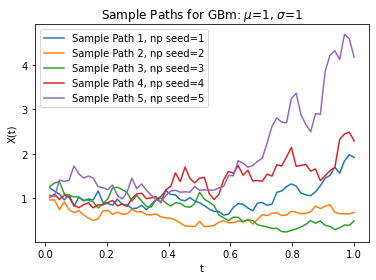

In [3]:
# TO DO!! - SET THIS SO THAT PATHS START AT 0!!! LEN=64=2**6... includes no 0 at front...
# set model parameters
mu, sigma, X_0 = 1, 1, 1 # we cannot start X at 0 or the solution is 0! If mu>>sigma, we see a linear trend as the drift is the dominant term

# time discretisation
T, N = 1.0, 2**6 #Force T as float, and 2**n for setting timesteps seems tractible
dt = T / N # Horizon time of 1 for normalisation. N arbitrary.
t_grid = np.arange(dt, dt+1, dt) #start, stop, step
# t_grid = np.insert(t_grid,0,0)

# Create and plot sample paths
num_paths = 5 # Number of paths we want to simulate (arbitrary)
for i in range(num_paths):
    # Create Brownian Motion
    np.random.seed(i+1)
    dW = np.sqrt(dt) * np.random.randn(N) # Increment: sqrt(dt)*random sample from N(0,1)
    W  = np.cumsum(dW) # Path = sum of increments
    
    # exact solution 
    X = X_0 * np.exp((mu - 0.5 * sigma**2) * t_grid + sigma * W)
#     X = np.insert(X,0,X_0)

    # Add line to plot
    plt.plot(t_grid, X, label = "Sample Path " + str(i+1)+", np seed="+str(i+1))

#Plotting
plt.title('Sample Paths for GBm: $\mu$=' + str(mu)+', $\sigma$='+str(sigma))
plt.ylabel('X(t)'); plt.xlabel('t')
# Add legend
plt.legend()

So now we have GBm working, we get a different trajectory each time due only to the random term W, which is our Wiener process (Brownian motion). Now we scale this up for many more paths using `num_paths` and we take a cross section across each of these at two seperate times to show that the mean of the paths is increasing as time goes on.

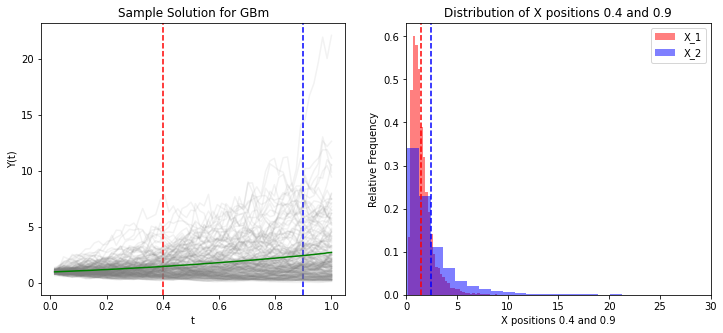

In [4]:
#NB: volatility and drift from prior cells carried through 
%matplotlib inline
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
plt.xlabel('t')
plt.ylabel('Y(t)')
plt.title('Sample Solution for GBm')

# Select and highlight cross section points: (recall T=1)
xpos1 = 0.4
xpos2 = 0.9
plt.axvline(x=xpos1, linestyle='--',color='red')
plt.axvline(x=xpos2, linestyle='--',color='blue')

# Simulate sample paths
X_1, X_2, X_total = [], [], []
num_paths = 10000
for i in range(num_paths): #ith path
    # Create Brownian Motion as above
    np.random.seed(i)
    dW = np.sqrt(dt) * np.random.randn(N) # ~N(0,1)*sqrt(dt) = N(0,t)
    W = np.cumsum(dW)
    
    # Exact Solution
    X = X_0 * np.exp(((mu - 0.5 * sigma**2) * t_grid) + (sigma * W))
    X_total.append(X) #save all trajectories to allow mean calc [num_paths rows, N points]
    
    X_1.append(X[int(xpos1 * N)]) #extract the X at particular points to allow mean calc.
    X_2.append(X[int(xpos2 * N)]) # as above
    
    # Plot first 200 sample paths on left
    if i < 200:
        ax.plot(t_grid, X, label = "Sample Path " + str(i), color = 'gray', alpha=0.1)

# Plot average line on left plot
ax.plot(t_grid, np.mean(X_total, 0), label="Mean " + str(i),color='green')


# Histogram plotting (NB: all fig 2 stuff below here)
fig.add_subplot(122)
num_bins = 50
plt.xlabel('X positions '+str(xpos1)+' and ' + str(xpos2)) 
plt.ylabel('Relative Frequency')
plt.xlim(0,30)
plt.title('Distribution of X positions '+str(xpos1)+' and ' + str(xpos2))
plt.hist(X_1,bins=num_bins,density=1,alpha=0.5, label='X_1', color = 'red')
plt.hist(X_2,bins=num_bins,density=1,alpha=0.5, label='X_2', color = 'blue')
# plt.xlim([0, 2])
plt.axvline(np.mean(X_total, 0)[int(xpos1 * N)],linestyle='--', color = 'red')
plt.axvline(np.mean(X_total, 0)[int(xpos2 * N)],linestyle='--', color = 'blue')
plt.legend()

The left plot shows the mean plotted where we can see the upward trend, and the right plot shows this for two specific positions as a histogram and you can see the peak also shifted to higher values for later times. NB - when I did this for $\mu = \sigma = 1$ this is quite clear as drift does not dominate the diffusion and we see our Wiener process contribution clearly. If we have say $\mu=1,\sigma=0.1$ the drift term now dominates, and the diffusion term appears as a small perturbation on top of it, and it is approximately linearly increasing. 

### Checking Implementation of GBm
* [Table of contents](#Table-of-contents)

To check whether we are able to recover the initial parameters in the model we do the following:
$$
X_t = X_0\exp\big(\big(\mu-\frac{1}{2}\sigma^2\big)t + \sigma W_t\big)
$$
Taking natural log both sides yields the log returns which is defined as $r_i$,
$$
r_i = \ln\bigg(\frac{X_{t}}{X_{0}} \bigg) = \big(\mu-\frac{1}{2}\sigma^2\big)t + \sigma\sqrt{t}Z
$$
where $\Delta W_t = \sigma\sqrt{t}Z$ and $Z \approx N(0,1)$. Taking expectation
$$
\mathbb{E}\bigg[\ln\bigg(\frac{X_{t}}{X_{0}} \bigg)\bigg] = \mathbb{E}\bigg[\big(\mu-\frac{1}{2}\sigma^2\big)t + \sigma\sqrt{t}Z\bigg]
$$
$$
 = \mathbb{E}\bigg[\big(\mu-\frac{1}{2}\sigma^2\big)t\bigg]+\mathbb{E}\bigg[ \sigma\sqrt{t}Z \bigg]
$$
$$
\label{eq:final}
 = \mathbb{E}\bigg[\big(\mu-\frac{1}{2}\sigma^2\big)t\bigg] = (\mu-\frac{1}{2}\sigma^2\big)t
$$
as the expectation of stochastic integral terms is zero due to the fact they are a martingale. Therefore we expect that the log returns (LHS) are equal to the final term on the RHS. The average log-returns are calculated below and compared (graphically) to the last RHS term.

We also compute the variance of the log returns to obtain an estimate as follows,

$$
var[r_i] = var\bigg[\big(\mu-\frac{1}{2}\sigma^2\big)t + \sigma W_t \bigg]\\
= var\bigg[\big(\mu-\frac{1}{2}\sigma^2\big)t \bigg] + var\big[\sigma W_t \big]
= 0 + var\big[\sigma W_t \big]
= \sigma^2 var\big[W_t \big]
= \sigma^2 \Delta t
$$
Rewriting this in terms of our estimator $\hat\sigma$ 
$$
\hat\sigma^2 = \frac{var[r_i]}{\Delta t} = \frac{\frac{1}{n-1} \sum_{i=1}^N (r_i - \hat\mu)^2}{\Delta t}
$$
and by defining the sample variance from our path in the usual way 
$$
S_\mu^2 = \frac{1}{n-1} \sum_{i=1}^N (r_i - \hat\mu)^2
$$
we can restate our $\hat\sigma$ as,
$$
\hat\sigma = sqrt{\frac{var[r_i]}{\Delta t}} = \frac{S_\mu}{\sqrt{\Delta t}}
$$
and the mean of the log returns [... is this from historical data?!],
$$
\hat\mu = \frac{1}{n}\sum_{i=1}^n r_i
$$
Therefore in the following the log returns are calculated

In [5]:
# Calculating average log returns - using the X_total from previous cell which is 
# a big array of all of the paths (rows = paths, cols = time)
X_stack = np.vstack(X_total)
print('X_stack.shape === ', X_stack.shape)
print('X_stack[0].shape === ', X_stack[0].shape)

X_stack_mean = np.mean(X_stack,0)
# plt.plot(X_stack_mean, label = 'stack')
# plt.plot(np.mean(X_total, 0), label = 'total', linestyle='--')
# plt.legend()

# Calculate average log returns
log_returns = np.zeros((num_paths,len(X_stack[0]))) # (5rows, 64 cols)
for i in np.arange(num_paths): #for each path i
    for j in np.arange(1,len(X_stack[i])): # for time j
        rets_Xij = np.log(X_stack[i][j]/X_stack[i][j-1]) #calculate log of returns Xj/Xj-1
        log_returns[i][j]=rets_Xij
av_log_returns = np.mean(log_returns, axis=0)

# Expectation/analytical mean
expectation = (mu - 0.5 * sigma**2)*dt #from equation

X_stack.shape ===  (10000, 64)
X_stack[0].shape ===  (64,)


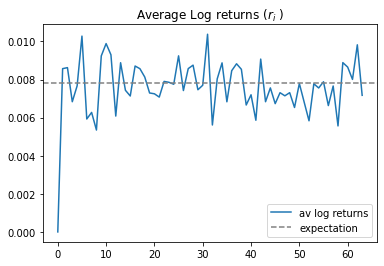

In [6]:
plt.plot(av_log_returns, label='av log returns')
plt.axhline(expectation,linestyle='--', color = 'gray', label = 'expectation')
plt.title('Average Log returns ($r_i$ )') 
plt.legend()

Plot shows here that the gray line, which is plotted at, 
$$
\label{eq:expectation}
\mathbb{E}\big[ r_i \big] = \mathbb{E}\bigg[ \ln\big( \frac{X_{t_i}}{X_{t_{i+1)}}}\big) \bigg] = \mathbb{E}\bigg[(\mu - \frac{1}{2}\sigma^2)T \bigg]
= (\mu - \frac{1}{2}\sigma^2)T 
$$
is representative of the the mean of the log returns as illustrated by the above plot, showing that the average log returns is indeed equal to the expectation, or analytical mean shown.

So now say we know that $\mu = 1$(which it is in our setup), using our solution can we recover the volatility? or mu? 
Rearranging above ($r_i$) to get:
$$
\label{eq:gbm_estimate_mu}
\hat{\mu} = \frac{\mathbb{E}[ r_i ]}{\Delta t} + \frac{1}{2} \sigma^2
$$
and using this to obtain,
$$
\label{eq:gbm_estimate_sigma}
\color{red}{\hat{\sigma} = \sqrt{\frac{var(r_i)}{\Delta t}}}
$$

Where $var(r_i)$ is the sample variance of the log returns $r_i$, given by the standard formula $\sigma_{\hat\mu}^2 = \frac{1}{n-1}\sum_{i=1}^{N}(r_i - \hat\mu)^2$. In the next cell, we observe how well the original parameters have been recovered:

In [7]:
# mu, sigma, T from above
print('T ==',T,', mu ==',mu,', sigma ==',sigma)
decimal_places = 4

mu_hat = (np.mean(av_log_returns)/dt) + 0.5*sigma**2
print('Getting original mu == ' , round(mu_hat,decimal_places) )

# recovered_sigma = np.sqrt( 2*((mu-np.mean(av_log_returns))/T))
sigma_hat = np.sqrt( np.var(log_returns)/dt )
print('Getting original sigma == ' , round(sigma_hat,decimal_places) )

print('{mu_hat}/{mu} == ', round(mu_hat/mu,decimal_places-1))
print('{sigma_hat}/{sigma}', round(sigma_hat/sigma,decimal_places-1))

T == 1.0 , mu == 1 , sigma == 1
Getting original mu ==  0.9869
Getting original sigma ==  0.9932
{mu_hat}/{mu} ==  0.987
{sigma_hat}/{sigma} 0.993


This has shown recovery of the original parameters to a good degree - for $\mu = \sigma = 1$ we get a recovery of 98.7% and 99.3% respectively. For $\mu = 1$, $\sigma = 0.1$ we get a recovery of 98.4% and 100.5% respectively  In summary, we set $\mu$ and $\sigma$ for use in the discretised GBm model, and obtained a path of random increments, and modelled the log returns. We then used the mean and variance of these log returns to see if we can recover the original solutions analytically. [... so is this GBm all sewn up?]

<a id="em-gbm-coarse-fine"></a>
### Euler Maramaya (EM) Approximation for GBm and effects of coarse or fine $\Delta t$
* [Table of contents](#Table-of-contents)

Showing that we get a better approximation for a smaller time discretisation - as $\Delta t$ decreases, the closer the approximation is to the true solution. As the timestep increases in size, the scheme is unstable and produces a poor fit to data. 

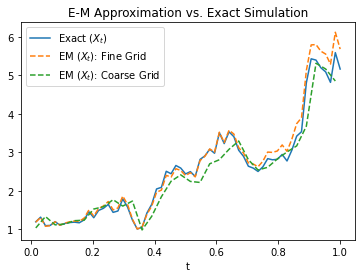

In [8]:
# Create Brownian Motion
np.random.seed(10)
dW = np.sqrt(dt) * np.random.randn(N) #N above
W  = np.cumsum(dW)

# Exact Solution
X_true = X_0 * np.exp((mu - 0.5*sigma**2)*t_grid + (sigma * W))

# Fine dt
X_EM_FINE, X = [], X_0 
#fine_grid = np.arange(dt, 1 + dt, dt)  #this is t from above, omit, and use t if you like
for j in range(N): 
    X += mu*X*dt + sigma*X*dW[j]
    X_EM_FINE.append(X)
#     if j<10:
#         print(X, t_grid[j])

# Coarse dt - Use R to make more coarse - dt = R*dt
X_EM_COARSE, X, R = [], X_0, 2
coarse_grid = np.arange(dt,1+dt,R*dt) 
coarse_err=[] 
for j in range(int(N/R)): 
    X += mu*X*(R*dt) + sigma*X*np.sum(dW[R*(j-1):R*j])
    X_EM_COARSE.append(X)
    
    coarse_err.append((np.abs(X_true[j]-X))/X_true[j]) 
    #capture error as a fraction of the true here as cant do it after! 
    
# plotting
plt.plot(t_grid, X_true, label="Exact ($X_t$)")
plt.plot(t_grid, X_EM_FINE, label="EM ($X_t$): Fine Grid", ls='--')
plt.plot(coarse_grid, X_EM_COARSE, label="EM ($X_t$): Coarse Grid", ls='--')
plt.title('E-M Approximation vs. Exact Simulation')
plt.xlabel('t')
plt.legend(loc=2)


ibid. Large $\Delta t$ results in a poor approximation - not a surprise, and reminds us to always keep $\Delta t$ small within the computational limits of hardware. Ask now how much error there is between the two, can I quantify how bad this has gotten with course grids, versus finer ones:

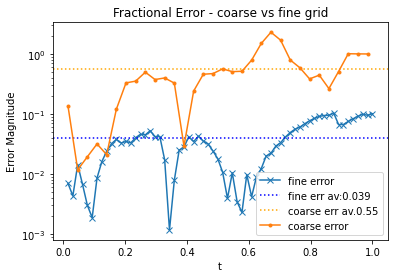

In [9]:
# Fractional Errors due to timestep
fine_err = (np.abs(X_true - X_EM_FINE))/X_true
plt.plot(t_grid, fine_err, marker='x', label='fine error')
# plt.axhline(1,linestyle='--', color = 'gray', label = '100% error')
plt.axhline(np.mean(fine_err),linestyle=':', color = 'blue', label = 'fine err av:'+str(round(np.mean(fine_err),3)))
plt.axhline(np.mean(coarse_err),linestyle=':', color = 'orange', label = 'coarse err av.'+str(round(np.mean(coarse_err),2)))

# plt.axhline(0.01,linestyle='--', color = 'gray', label = '1% error')
#Log plot to show up the differences better
plt.semilogy(coarse_grid, coarse_err, marker='.', label = 'coarse error')
plt.title('Fractional Error - coarse vs fine grid')
plt.xlabel('t')
plt.ylabel('Error Magnitude') 
plt.legend(loc = 0)

The plot above shows that for the coarse grid, the fractional error (i.e. distance between true and approximated as a proportion of the true) are consistently higher than that of the fine grid (see legend for values), which is just a more quantified way of showing what we can 'eyeball' from the previous plot. With the exception of a few isolated periods, but these dont seem to form any kind of pattern and seem arbitrary - propose this is an artefact of the random variation?

<a id="milstein-gbm"></a>
#### Milstein Method: GBm
* [Table of contents](#Table-of-contents)

Adding a second-order "correction" (Ito-Taylor expansion?) term to our previous brownian motion we can achieve the higher order Milstein Scheme. This now requires the use of the partial differentiation of the function $b$, but does have the advantage of faster strong convergence, therefore requiring fewer computations compared to its equivalent Euler computation (see convergence).
$$
\label{eq:milstein_1}
X_{n+1} - X_n = a(X_n)\Delta t + b(X_n)\Delta W_n \color{red}{+ \frac{1}{2}b(X_n)\;\partial_Xb(X_n)\left((\Delta W_n)^2-\Delta t\right)} + \tilde R
$$

where $a(X_n) = \mu X_n$ and $b(X_n) = \sigma X_n$, $\tilde R$ is remainder terms from the Ito Taylor expansion used to obtain this scheme. This implies the following for our Geometric Brownian Motion example

$$
\label{eq:milstein_2}
X_{n+1} = X_n + \mu X_n \Delta t + \sigma X_n \Delta W_n \color{red}{+ \frac{1}{2}\sigma^2 X_n\left((\Delta W_n)^2-\Delta t\right)}
$$
I feel like ive just omitted the R and havent justified... should say something like... "The error term $\tilde R \sim \mathcal{O}(\Delta t ^ {1/2})$"

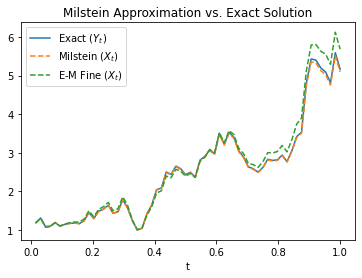

In [10]:
# Milstein Approximation
Xmilstein, X_milstein_err, X = [], [], X_0
for j in range(N):  
    X += mu*X*dt + sigma*X*dW[j] + 0.5 * sigma**2 * X * (dW[j] ** 2 - dt)
    Xmilstein.append(X)
    X_milstein_err.append((np.abs(X_true[j]-X))/X_true[j])

    
# Plot
plt.plot(t_grid, X_true, label="Exact ($Y_t$)")
plt.plot(t_grid, Xmilstein, label="Milstein ($X_t$)",ls='--')
# plt.plot(coarse_grid, X_EM_COARSE, label="E-M Coarse ($X_t$)",ls='--')
plt.plot(t_grid, X_EM_FINE, label="E-M Fine ($X_t$)",ls='--')
plt.title('Milstein Approximation vs. Exact Solution')
plt.xlabel('t')
plt.legend(loc=2)

The Milstein scheme gives a better fit to the path used here, shown in the above plot.

<a id="euler-ou"></a>
#### Ornstein-Uhlenbeck Process by Euler Maramaya
* [Table of contents](#Table-of-contents)


The general form of the OU process is given as 
$$
dX_t= (a-bX_t)dt + \sigma dW_t
$$
as opposed to GBm, this process (also known as the Vasicek model) has a drift term which depends on the current value of the process, and contains an extra term.

Commonly, an extra 'time constant' is introduced so I modeled this, and had a little play with the parameter 'tau'. Another variation has a multiplied of $\sqrt{\frac{2}{\tau}}$ which again, im not sure I understand the significance of.

<!-- $$
dX = -\frac{1}{\tau}(x-\mu)dt + \sigma \sqrt{\frac{2}{\tau}}dW
$$ -->
$$
dX = -\frac{1}{\tau}(x-\mu)dt + \sigma dW
$$
where $dW = \sqrt{dt}\times N(0,1)$.

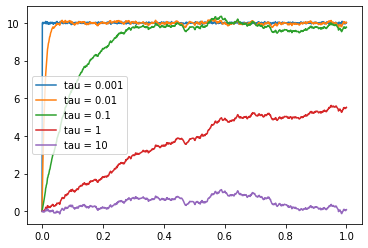

In [11]:
# OU Process with time constant tau

sigma, mu = 1., 10.  # Standard deviation, mean
tau = 1  # Time constant
tau_var = [0.001, 0.01,0.1, 1, 10]

T, N = 1.0, 1000
dt = T/N  # Time step
dW = np.sqrt(dt) * np.random.randn(N)

t_discrete = np.linspace(0., T, N) # Vector of times.
X = np.zeros(N)
for tau_ in tau_var:
    for i in range(N - 1):
    #     X[i+1] = X[i] + (-(X[i] - mu) * dt / tau) + (sigma * np.sqrt(2/tau)) * dW[i]
        X[i+1] = X[i] + (-(X[i] - mu)/tau_) * dt + sigma * dW[i]
    plt.plot(t_discrete, X, label='tau = '+str(tau_)) 
plt.legend()

This shows one realisation of the process for several values of tau to see what that does. In theory the 1/tau is the mean reversion speed, the higher tau is, the smaller 1/tau is so the slower 

<a id="ou-theory"></a>
#### The Ornstein Uhlenbeck process post nightmares
* [Table of contents](#Table-of-contents)

So now we have the equation...
$$
\label{eq:ou_process}
d X_t = \kappa(\theta - X_t)dt + \sigma dW_t
$$

where $\kappa$ is the speed of mean reversion, $\theta$ and $\sigma$ are the long term mean and volatility of the process respectively, and $X_t$ is the value of the process at time t. The process forms the basis of the Vasicek model for short interest rates, and was first proposed in 1977. Note here that if we have conditions such that $\theta \lt X_t$ then the drift term becomes negative, and the drift forces the process in the direction of the long term mean. 

The analytical solution to this is as follows.
$$
\label{eq:ou_solution}
X_T = X_0 e^{-kT} + \theta(1-e^{-kT})+ \sigma \int_{0}^T e^{-k(T-t)} dW_t
$$

With mean and variance,
$$
\label{eq:ou_mean_variance}
\mathbb{E}[X] = X_0 e^{-kT} + \theta(1-e^{-kT})\\
var[X] = \frac{\sigma^2}{2k}(1-e^{-2kT})
$$

We also know from taking the limit as $T \rightarrow \infty$
$$
\label{eq:ou_mean_limit}
\lim_{T\rightarrow\infty} \mathbb{E}[X] = \lim_{T\rightarrow\infty}\big[X_0 e^{-kT} + \theta(1-e^{-kT})\big]\\
= X_0 \lim_{T\rightarrow\infty} e^{-kT}+\theta(1-\lim_{T\rightarrow\infty} e^{-kT}) = \theta \\
\lim_{T\rightarrow\infty} var[X] = \lim_{T\rightarrow\infty} \big[ \frac{\sigma^2}{2k}(1-e^{-2kT})\big]
$$

$$
\label{eq:ou_variance_limit}
\lim_{T\rightarrow\infty} var[X] = \lim_{T\rightarrow\infty} \big[ \frac{\sigma^2}{2k}(1-e^{-2kT})\big] \\
$$
The limit of the mean here displays the mean reverting property, but the variance is dependent on the speed of mean reversion, k. The higher the speed of mean reversion, the higher the drift towards the mean (quicker the convergence) and the lower the variance. Therefore this inverse relationship is entirely expected.

For a general start time t $\neq 0$, and increment size $\Delta t$ we have:
$$
\label{eq:ou_mean_var_approx}
\mathbb{E}[X_{t + \Delta t}] = X_t e^{-k\Delta t} + \theta(1-e^{-k\Delta t})\\
var[X_{t + \Delta t}] = \frac{\sigma^2}{2k}(1-e^{-2k\Delta t})
$$

We know that for a fixed value of X, we have normally distribution as
$$
\label{eq:ou_solution_approx}
X_{t + \Delta t} = X_t e^{-k\Delta t} + \theta(1-e^{-k\Delta t}) + \sigma \sqrt{\frac{(1-e^{-2k\Delta t})}{2k}}Z
$$
where $Z\sim N(0,1)$ and $\Delta t$ is the increment between timesteps, and is a constant. This is comparable to an autroregressive process of order 1 (time series?)
$$
\label{eq:ou_autoregressive}
y_{i+1} = b y_i + a + \epsilon_{i+1} \\
b=e^{-k\Delta t} \\
a =\theta\:(1-e^{-k\Delta t}) \\
\epsilon = \sigma \sqrt{\frac{(1-e^{-2k\Delta t})}{2k}}Z
$$
If we can obtain $a$ and $b$ from data, and then using our knowledge of $k$ and $\Delta t$ we can obtain estimates for $\theta$ and $\sigma$

Variance Calcs:
np.var(X) =  0.12505
var_exact 0.000999


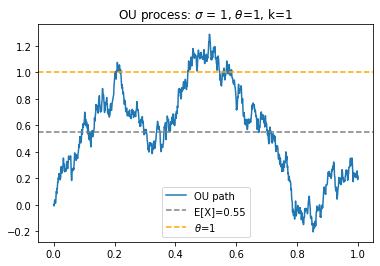

In [12]:
#Ornstein Uhlenbeck Process - Euler Marumaya discretisation

sigma, theta, k = 1, 1, 1 # Standard deviation, mean, mean reversion speed

T, N = 1.0, 1000
dt = T/N  # Time step
Z = np.random.randn(N)

t_grid = np.linspace(0., T, N) # Vector of times.
X = np.zeros(N)
for i in range(N-1): 
    X[i+1] = X[i]*np.exp(-k*dt) + theta*(1-np.exp(-k*dt)) + sigma*np.sqrt( (1-np.exp(-2*k*dt))/(2*k) )*Z[i] 

#mean and variance of process:
expectation = np.mean(X)
variance = np.var(X)
#variance from analytical solution:(mean exact is theta - see plot)
var_exact = (sigma**2/(2*k)) * (1-np.exp(-2*k*dt))

plt.plot(t_grid, X, label = 'OU path')
plt.axhline(expectation,linestyle='--', color = 'gray', label = 'E[X]='+str(round(expectation,2)))
plt.axhline(theta,linestyle='--', color = 'orange', label = '$\\theta$='+str(theta))
plt.title('OU process: $\sigma$ = ' + str(sigma)+', $\\theta$='+str(theta)+', k='+str(k))
plt.legend()

print('Variance Calcs:\nnp.var(X) = ', round(variance,5))
print('var_exact', round(var_exact,6))


We see in this plot that the calculated mean from the generated path, and the analytical mean are not close, unless the value of k is high. Given a set of parameters, how long is the horizon time before we observe our mean reversion? I.e, how long does it take for our process to show the property $X\sim N(\theta, \frac{\sigma^2}{2k})$. Using the concept of half life, we aim to calculate a value of t, namely $t_{1/2}$ that satisfies:
$$
\label{eq:ou_half_life}
\mathbb{E}[X_{t_{1/2}}] = X_0 + \frac{\theta - X_0}{2}
$$

given that this is the half way point between the value of the process at $X_0$, and the long term mean $\theta$. Using this expression we can observe the following:

$$
\label{eq:ou_halflife_deriv}
\mathbb{E}[X_{t_{1/2}}] = X_0 + \frac{\theta - X_0}{2} \\
X_0 e^{-k t_{1/2}} + \theta (1- e^{-k t_{1/2}}) = X_0 + \frac{1}{2}(\theta - X_0)\\
X_0 e^{-k t_{1/2}} + \theta - \theta e^{-k t_{1/2}} = X_0 + \frac{1}{2}(\theta - X_0)\\
e^{-k t_{1/2}} = \frac{2 X_0 + \theta - 2\theta - X_0}{2}
e^{-k t_{1/2}} = \frac{1}{2}
$$

Therefore;
$$
\label{eq:ou_halflife_result}
t_{1/2} = \frac{-ln(1/2)}{k}
$$

This means that the horizon needed to observe mean reversion is inversely proportional to the mean reversion speed which makes perfect sense - for a higher speed of mean reversion, the shorter the time needed to observe the process reach its mean value.  For $k=3$, we therefore calculate $t_{1/2}=$


## Maximum Likelihood Estimation
* [Table of contents](#Table-of-contents)
<!-- https://www.stat.pitt.edu/si/Satish,Paul%20paper1.pdf -->

Maximum Likelihood Estimation (MLE) is a method by which parameters within a distribution can be estimated. The method assumes inherently that probability distribution function is available, and that the log likelihood function (below) is differentiable with respect to the parameters to be estimated. The aim of MLE is to maximise the likelihood function, or equivalently to minimise the negative log likelihood function, $L$. 
$$
\label{eq:mle-likelihood}
L(\theta|X) = \prod_{t=1}^N f(X_t|\theta)
$$

where $\theta$ is a vector of parameters, and $X_t$ is the process with probability density function $f$. Taking the logarithm of the likelihood function does not affect the position at which the function would be maximised and it allows for easier manipulation of the function. Therefore maximising the log likelihood is equivalent to maximising the likelihood, $f$.

$$
\label{eq:mle-loglikelihood}
\ln \big( L(\theta|X) \big) = \ln \big( \prod_{t=1}^N f(X_t|\theta) \big)
$$

If we assume for illustration that $\theta = (\mu, \sigma)^T$, we maximise the log likelihood function setting our differentiation with respect to each parameter to zero, and solve to obtain estimates for parameters in $\theta$.

$$
\label{eq:partial_loglikelihood}
\frac{\partial }{\partial \theta} \ln \big( L(\theta|X) \big) = 0\\
\frac{\partial}{\partial \mu}  \ln \big( L(\theta|X) \big)= 0
$$

## CKLS Model
* [Table of contents](#Table-of-contents)

The CKLS (Chan, Karolyi, Longstaff, Sanders) model is a one-factor interest rate model, other examples include:
 - Vasicek, 1977, $dr_t = \alpha_t(\beta_t-r_t)dt + \sigma dW_t$
 - Cox Ingersoll Ross, 1985 that allows for negative rates, $dr_t = \alpha(\beta-r_t)dt + \sigma \sqrt{r_t} dW_t$
 - Hull-White, 1990, $dr_t = (\alpha_t-\beta r_t)dt + \sigma dW_t$ 
 - CKLS, 1992, $dr_t = \alpha(\beta-r_t)dt + \sigma r_t^\gamma dW_t$
 
Thus, the CKLS model includes both Ornstein Uhlenbeck processes (i.e. the Vasicek model) and the CIR model, and was presented as a more general short rate model. Simply by changing the parameters $\alpha$, $\beta$ and $\gamma$ one can achieve any of the other models. 

To state the model more completely, ...
$$
\label{eq:ckls}
dX_t = (\alpha - \beta X_t)dt + \sigma X_t^\gamma dW_t\\
X_0 = X(0)\text{ at t=0}
$$

where $W_t$ is a standard wiener process, distributed as $N(0,t)$. When the parameter $\gamma = \frac{1}{2}$, we can see that the model reduces to the CIR (square root) model. We can further see that when $\gamma = 0$ we recover the Vasicek model. Finally, with $\alpha = 0$ and $\gamma = 1$, we have Geometric Brownian Motion.

The CKLS model posesses no closed form solution, so we must look immediately to discretise this equation. Once again we can simulate this using the Euler-Maramaya method resulting in the following discretisation.
$$
\label{eq:ckls_discretisation}
X_{t} - X_{t-1} = (\alpha - \beta X_{t-1})\Delta t  + \sigma X_{t-1}^\gamma \sqrt{\Delta t} Z \\
\Delta X = (\alpha - \beta X_{t-1})\Delta t  + \sigma X_{t-1}^\gamma \sqrt{\Delta t} Z
$$
where $Z \sim N(0,1)$, such that $W_t \equiv Z\sqrt{t}$, and $\Delta X = X_{t} - X_{t-1}$.

From this we can derive a transition density,
$$
\label{eq:ckls_transition_density}
f(X_t | X_{t-1}) = ...
$$
which leads to a likelihood function given by
$$
\label{eq:ckls_likelihood}
L(\{X_i \}_{i=1}^{N} | \theta) = ...
$$
and log likelihood...
$$
\label{eq:ckls_log_likelihood}
\ln(L(\{X_i \}_{i=1}^{N} | \theta)) = ...
$$

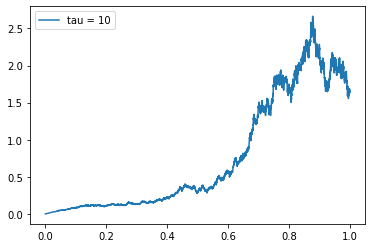

In [13]:
# CKLS Process by Euler

alpha, beta, sigma, gamma = 1., 1., 1., 1. #are these sensible?
T, N = 1.0, 10000
dt = T/N 
# np.random.seed(101) #uncomment to make this static results
dW = np.sqrt(dt) * np.random.randn(N) # root(dt) * Wt
t_discrete = np.linspace(0., T, N)

X = np.zeros(N)

for i in range(N - 1):
    X[i+1] = X[i] + (alpha - beta * X[i]) * dt + sigma * X[i]**gamma * dW[i]
    
plt.plot(t_discrete, X, label='tau = '+str(tau_)) 
plt.legend()

In [14]:
# np.random.seed(10)
np.random.randn(10)

array([ 1.0156398 ,  0.01908981, -0.90883477,  1.21162055,  0.68100394,
        0.14644604, -0.41080335, -0.40285885, -1.61860063, -0.51443362])

### Convergence
* [Table of contents](#Table-of-contents)

We think of convergence as the change in 'distance' between a numerical approximation of a process, and the true value. If over time the approximation approaches the true solution i.e. our distance decreases, the numerical scheme is said to converge with time to the true value, with a rate $\beta$. 
In the Euler Marumaya (EM) method, as we decrease the $\Delta t$ the numerical approximation becomes an increasingly closer match to the true solution, i.e. the two converge as $\Delta t \rightarrow 0$. In this case, we can have that either $\Delta t \rightarrow 0$ or $N \rightarrow \infty$ to achieve convergence. The rate of the convergence depends on how we quantify the distance between the two processes. Calculating the strong and weak error, are two ways to quantify this difference, resulting in two different rates of convergence.

#### Strong error

The strong error considers the error between the solution generated by the numerical scheme, and the true solution for every value of time in a sample path, given that both are based on the same brownian increments. We are essentially looking at the pathwise difference between two random variables. The strong error is defined below.
$$
\label{eq:strong-error}
\mathrm{e}_{\mathbf{s}}(h):= \sup_{0 \leq t_n \leq T} \mathbb{E}\big|X_{n}^{(h)}-X_{t_n}\big|\\
$$

where $X_{n}^{(h)}$ is interpreted as the numerical approximation of a random variable X, by a numerical scheme of timstep/partition size $h = \Delta t = t_{i+1} - t_{i}$ at time $t_n$. The term $X_{t_n}$, is the true solution to which the numerical approximation is compared, at time $t_n$. The process is said to be strongly convergent if $\mathrm{e}_{\mathbf{s}}(h) \rightarrow 0$ as $h \rightarrow 0$. The strong error is interpreted as the expectation/mean of the pathwise errors. 

A scheme converges strongly with rate $\beta$ if $\exists c \gt 0$ such that $\mathrm{e}_{s}(h) = c h ^{\beta}$, and the constant $c$ is independent of $n$ and $h$.

It is often the case that the strong error is not able to be calculated directly, and in such cases the mean square error (MSE) can be used in its place, because it dominated the strong error from above as,

$$
\mathrm{e}_{s}(h) =\sup_{0 \leq t_n \leq T} \mathbb{E}\big|X_{n}^{(h)}-X_{t_n}\big| \leq  \sup_{0 \leq t_n \leq T} \mathbb{E}\bigg(\big|X_{n}^{(h)}-X_{t_n}\big|^2\bigg) ^{1/2} = \text{rMSE}
$$

#### Weak error

In the weak error we are capturing the average behaviour of a process with time, i.e. the first moment. Given the function $\phi$ in the class of polynomials up to degree k, the weak error of the processes $X_{n}^{(h)}$ and $X_{t_n}$ defined above is

$$
\label{eq:weak_error}
\mathrm{e}_{w}^{(h)} = \sup_{0\leq t_n \leq T}|\mathbb{E}[\phi (X_n^{(h)})] - \mathbb{E}[\phi (X_{t_n})] |
$$
This error is interpreted as the error between the means, or first moments. A scheme converges weakly with rate $\beta$ if $\exists c \gt 0$ such that $\mathrm{e}_{w}^{(h)} = c h ^{\beta} = \mathcal{O}(h^{\beta})$, and the constant $c$ is independent of $n$ and $h$. 

Further, this convergence is of order $\beta$ if:
$$
\label{eq:weak-order}
\mathrm{e}_{\Delta t}^{weak} \leq K h^{\beta}
$$

#### Convergence of Euler and Milstein Schemes

The Euler scheme converges weakly and strongly over our time partition as:
$$
\label{eq:euler_convergence}
\mathrm{e}_{w}^{(h)} = \sup_{0\leq t_n \leq T}|\mathbb{E}[\phi (X_n^{(h)})] - \mathbb{E}[\phi (X_{t_n})] | \leq ch^1\\
\mathrm{e}_{\mathbf{s}}(h) = \sup_{0 \leq t_n \leq T} \mathbb{E}\big|X_{n}^{(h)}-X_{t_n}\big| \leq ch^{1/2}
$$
meaning we have weak convergence of order $\beta=1$ and strong convergence of order $\beta=1/2$. Therefore if we wish to half our strong error, we must quadruple the number of points in the time partition, and to reduce the weak error by half we must double. This illustrates the computational cost of both error reductions.

The Milstein Scheme converges with the following strong and weak errors,
$$
\label{eq:milstein_convergence}
\mathrm{e}_{w}^{(h)} \leq ch^1\\
\mathrm{e}_{\mathbf{s}}(h) \leq ch^{1}
$$
illustrating that advantage that the Milstein scheme converges faster in terms of the strong error, with less computations. So, providing we have a differentiable function as required by the milstein scheme, we may achieve a better match to our analytical solution pathwise.

#### EM Weak Convergence
* [Table of contents](#Table-of-contents)

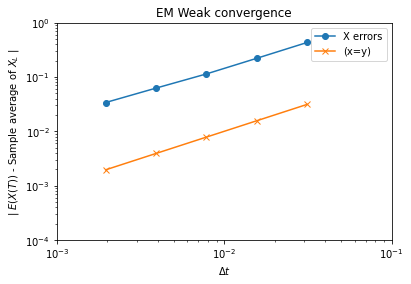

q =  0.91652
residual =  0.05109
Convergence order (weak): beta =  0.9178239406632378


In [15]:
# Test weak convergence of Euler-Maruyama
# SDE is dX = mu*X dt + sigma*X dW,  X(0) = X_0
#      where mu = 2, sigma = 0.1, and X_0 = 1
#
# E-M uses 5 different timesteps: 2^(p-10),  p = 1,2,3,4,5.
# Examine weak convergence at T=1:  | E (X_L) - E (X(T)) |.
#
# Different paths are used for each E-M timestep.
# Adapted from 
# Desmond J. Higham "An Algorithmic Introduction to Numerical Simulation of 
#                    Stochastic Differential Equations"
# http://www.caam.rice.edu/~cox/stoch/dhigham.pdf

np.random.seed(102)
mu=2
sigma=0.1
X_0=1
T=1
M=50000

Xem=np.zeros((5,1))
for p in range(1,6): # for all Dt values
    Dt = 2**(p-10)
    L=float(T)/Dt
    Xtemp=X_0*np.ones((M,1))
    
    for j in range(1,int(L)+1): #for each time along the path
        Winc=np.sqrt(Dt)*np.random.randn(M) #random increment
        Xtemp += Dt*mu*Xtemp + sigma*np.multiply(Xtemp.T,Winc).T
    Xem[p-1] = np.mean(Xtemp,0)
Xerr = np.abs(Xem - np.exp(mu))

Dtvals=np.power(float(2),[x-10 for x in range(1,6)])
plt.loglog(Dtvals,Xerr, 'o-', label='X errors')
plt.loglog(Dtvals,Dtvals, 'x-', label='(x=y)')
plt.axis([1e-3, 1e-1, 1e-4, 1])
plt.xlabel('$\Delta t$')
plt.ylabel('| $E(X(T))$ - Sample average of $X_L$ |')
plt.title('EM Weak convergence')
plt.legend()
plt.show()

### Least squares fit of error = C * Dt^q ###
A = np.column_stack((np.ones((p,1)), np.log(Dtvals)))
rhs=np.log(Xerr)
sol = np.linalg.lstsq(A,rhs,rcond=None)[0]
q=sol[1][0]
resid=np.linalg.norm(np.dot(A,sol) - rhs)
print('q = ', round(q,5))
print('residual = ', round(resid,5))

# Slope of the loglog to get convergence order beta
beta = (np.log(Xerr[-1]/Xerr[0])) / (np.log(Dtvals[-1]/Dtvals[0]))
print('Convergence order (weak): beta = ', np.mean(beta))

#### EM Strong Convergence
* [Table of contents](#Table-of-contents)

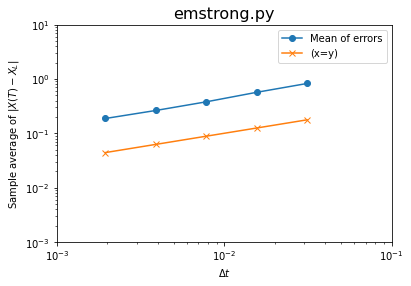

residual =  0.03442
q = 0.5385
Convergence order (strong): beta =  0.5120301704428962


In [16]:
# EMSTRONG Test strong convergence of Euler-Maruyama
# SDE is dX = mu*X dt + sigma*X dW,  X(0) = X_0
#      where mu = 2, sigma = 1, and X_0 = 1
#
# Discretized Brownian path over [0,1] has dt = 2^(-9).
# E-M uses 5 different timesteps: 16dt, 8dt, 4dt, 2dt, dt.
# Examine strong convergence at T=1:  E | X_L - X(T) |.
#
# Adapted from 
# Desmond J. Higham "An Algorithmic Introduction to Numerical Simulation of 
#                    Stochastic Differential Equations"
# http://www.caam.rice.edu/~cox/stoch/dhigham.pdf

np.random.seed(100)

mu=2
sigma=1
X_0=1
T=1
N=2**9
dt = float(T)/N
M=1000 #

Xerr=np.zeros((M,5))
for s in range(M):
    dW=np.sqrt(dt)*np.random.randn(1,N)
    W=np.cumsum(dW)
    Xtrue = X_0*np.exp((mu-0.5*sigma**2)*T+sigma*W[-1])
    for p in range(5): #for each power
        R=2**p 
        Dt=R*dt
        L=N/R
        Xem=X_0
        for j in range(1,int(L)+1):  # for each step in the path
            Winc=np.sum(dW[0][range(R*(j-1),R*j)])
            Xem += Dt*mu*Xem + sigma*Xem*Winc
        Xerr[s,p]=np.abs(Xem-Xtrue)

Dtvals=dt*(np.power(2,range(5)))
plt.loglog(Dtvals,np.mean(Xerr,0),'o-', label='Mean of errors')
plt.loglog(Dtvals,np.power(Dtvals,0.5),'x-',label='(x=y)')
plt.axis([1e-3, 1e-1, 1e-3, 10])
plt.xlabel('$\Delta t$')
plt.ylabel('Sample average of $|X(T)-X_L|$')
plt.title('emstrong.py',fontsize=16)
plt.legend()
plt.show()

### Least squares fit of error = C * Dt^q ###
A = np.column_stack((np.ones((5,1)), np.log(Dtvals)))
rhs=np.log(np.mean(Xerr,axis=0))
sol = np.linalg.lstsq(A,rhs,rcond=None)[0]
q=sol[1]
resid=np.linalg.norm(np.dot(A,sol) - rhs)
print('residual = ', round(resid,5))
print('q =', round(q,5))

# Slope of the loglog to get convergence order beta
beta = (np.log(Xerr[-1]/Xerr[0])) / (np.log(Dtvals[-1]/Dtvals[0]))
print('Convergence order (strong): beta = ', np.mean(beta))

In [17]:
sol

array([1.6644591 , 0.53849735])

#### Milstein Strong convergence
* [Table of contents](#Table-of-contents)

residual =  0.03847
q =  1.04259


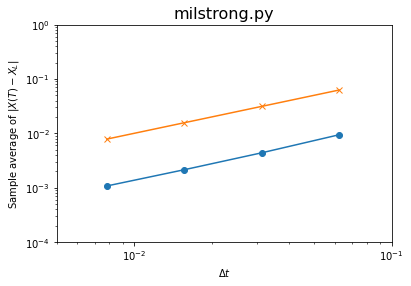

Convergence order (strong):??? beta =  0.6840227655281962


In [18]:
#MILSTRONG Test strong convergence of Milstein
#
# SDE is  dX = r*(K-X) dt + beta*X dW,   X(0) = Xzero,
#       where r = 2, K = 1, beta = 0.25, Xzero = 0.5.
#
# Discretized Brownian path over [0,1] has dt = 2^(-11).
# Milstein uses timesteps 128*dt, 64*dt, 32*dt, 16*dt (also dt for reference).
# Examines strong convergence at T=1:  E | X_L - X_T |.
# Adapted from 
# Desmond J. Higham "An Algorithmic Introduction to Numerical Simulation of 
#                    Stochastic Differential Equations"
# http://www.caam.rice.edu/~cox/stoch/dhigham.pdf

np.random.seed(100)
r=2; K=1; beta=0.25; Xzero=0.5
T=1; N=2**11; dt=float(T)/N
M=500
R = [1, 16, 32, 64, 128]

dW = np.sqrt(dt)*np.random.randn(M,N)
Xmil = np.zeros((M,5))
for p in range(5):
    Dt = R[p]*dt; L=float(N)/R[p]
    Xtemp=Xzero*np.ones(M)
    for j in range(1,int(L)+1):
        Winc=np.sum(dW[:,range(R[p]*(j-1),R[p]*j)],axis=1)
        Xtemp += r*(K-Xtemp)*Dt + beta*Xtemp*Winc + 0.5*beta**2*Xtemp*(np.power(Winc,2)-Dt)
    Xmil[:,p] = Xtemp

Xref = Xmil[:,0]
Xerr = np.abs(Xmil[:,range(1,5)] - np.tile(Xref,[4,1]).T)
Dtvals = np.multiply(dt,R[1:5])

plt.loglog(Dtvals,np.mean(Xerr,0),'o-')
plt.loglog(Dtvals,Dtvals,'x-')
plt.axis([5e-3, 1e-1, 1e-4, 1])
plt.xlabel('$\Delta t$'); plt.ylabel('Sample average of $|X(T)-X_L|$')
plt.title('milstrong.py',fontsize=16)

#### Least squares fit of error = C * Dt^q ####
A = np.column_stack((np.ones((4,1)), np.log(Dtvals)))
rhs=np.log(np.mean(Xerr,0))
sol = np.linalg.lstsq(A,rhs,rcond=None)[0]; q=sol[1]
resid=np.linalg.norm(np.dot(A,sol) - rhs)
print('residual = ', round(resid,5))
print('q = ', round(q,5))
plt.show()

# Slope of the loglog to get convergence order beta
beta = (np.log(Xerr[-1]/Xerr[0])) / (np.log(Dtvals[-1]/Dtvals[0]))
print('Convergence order (strong):??? beta = ', np.mean(beta))

## Explicit and Implicit
* [Table of contents](#Table-of-contents)
This site was quite good to get the ideas going...[https://www.flow3d.com/resources/cfd-101/numerical-issues/implicit-versus-explicit-numerical-methods/]

An explicit scheme is one that is computed only from known quantities, i.e. using a previous timestep. So if we are simulating a process $X_t$ and our scheme is only dependent on $X_{t-1}$ then the scheme is said to be explicit. 

If our simulation scheme is dependent on the current, and the previous timestep, or if our dependent variables are detemined by coupled sets of equations then the scheme is said to be implicit. 

### Numerical stability
What happens to the solution as the timestep is increased in size? The Euler scheme will break down for a small timestep, so I guess you need to find out how small you can go before the thing breaks down? IS that the chat? So for Milstein, i presume it will be smaller as it privides a closer aproximation with less or smaller timesteps? am i mad?

## Heston
* [Table of contents](#Table-of-contents)

The Heston model first proposed by Steve Heston in 1993 is used for the pricing European options and unlike the Black and Scholes option pricing model which utilises Geometric Brownian Motion, the Heston model assumes that the volatility itself is also stochastic. Therefore the model comprises of a pair of SDEs - one for the price process $X_t$ and one for the volatility process $\nu_t$. 

The Heston model is dinstinguishable from other methods, boasting these characteristics [investopedia!]:
- Includes correlation between stocks price and volatility
- Volatility is a mean reverting process
- Closed form solutions available to both processes
- No requirement that price follows a lognormal probability distribution

The price pocess is given as the following SDE
$$
\label{eq:heston-model}
dX_t = r X_t dt + \sqrt{\nu_t}X_t dW_{1t} \\
d\nu_t = k(\theta - \nu_t)dt + \sigma_\nu \sqrt{\nu_t}dW_{2t}
$$
where $dW_{1t}$ and $dW_{2t}$ are two correlated wiener processes, with correlation $\rho \in[-1,1]$, and,
$
\label{eq:heston_vars}
X_t = \text{asset price at time t}\\
r = \text{risk-free interest rate}\\
\nu_0 = \text{initial volatility}\\
\sigma_\nu = \textrm{volatility of the volatility $\nu_t$}\\
\theta = \textrm{long term price variance}\\
k = \textrm{rate of mean reversion to \theta}\\
dt = \textrm{time increment, dt\gt0}\\
W_{1t} = \textrm{brownian motion of the asset price}\\
W_{2t} = \textrm{brownian motion of the asset price variance}\\
\rho = \textrm{correlation between price and volatility brownian motions}
$
    
NB: Both of these processes can be modeled using the CKLS model by changing the parameters! The volatility process is given as a CIR (square root) process

It can be shown that if the parameters obey the Feller condition [wiki] 
$$
\label{eq:feller}
2k\theta\lt\sigma^2
$$
where $\sigma$ is the volatility of the volatility, then the process $\nu_t$ is strictly positive. As in the model we take the $\sqrt{\nu_t}$ we are bound to have a non-negative volatility process. The volatility can hit 0 when $\nu = k^2 / 2$, and can still approach 0 when the Feller condition holds [Kouritzin2018](https://arXiv.org/pdf/1608.02028.pdf). Kouritzen also states "from a financial perspective that hitting zero implies randomness coming out of the price, which is not common so we generally have $\nu \gt k^2 / 2$". 
Is $\rho$ often negative in financial markets? How could i possibly know that!?


Discretisation of the processes... (EM)

$$
X_{t_{i+1}} - X_{t_i} = r X_{t_i} \Delta t + X_{t_i} \sqrt{\nu_{t_i}} \sqrt{\Delta t} Z_{t_i}\\
\nu_{t_{i+1}} - \nu_{t_{i}} = (\alpha - \beta \nu_{t_i})\Delta t + \sigma_\nu \sqrt{\nu_{t_i}}\sqrt{\Delta t} Z
$$
where $Z\sim N(0,1)$, and $dW_t = \sqrt{\Delta t} Z$. 
However as the process itself is continuous and the discretisation is by definition finite, it is possible for errors to be introduced and it is possble that $\nu_{t+1} \lt 0$ can occur. [This is a consequence of the model and not an observable effect (I DONT KNOW WHY!)](https://www.quantstart.com/articles/Heston-Stochastic-Volatility-Model-with-Euler-Discretisation-in-C/).

Within the model we can take a function of the volatility each time it occurs, to enable us to avoid numerical problems should $\nu_{t+1} \lt 0$. The model discretisation could be modified like so 
$$
\label{eq:heston_vol_negatives}
\nu_{t_{i+1}} = f_1(\nu_{t_{i}}) + (\alpha - \beta f_2(\nu_{t_{i}}))\Delta t + \sigma_\nu \sqrt{f_3(\nu_{t_{i}}})\sqrt{\Delta t} Z
$$
and a popular choice termed 'full truncation' for the functions are as follows:
$$
f_1(x) = x \\
f_2(x) = max(0,x) \\
f_3(x) = max(0,x)
$$
which finally results in,
$$
\label{eq:heston_vol_nonegs}
\nu_{t_{i+1}} = \nu_{t_{i}} + (\alpha - \beta \nu_{t_{i}}^{+})\Delta t + \sigma_\nu \sqrt{\nu_{t_{i}}^+}\sqrt{\Delta t} Z \\
X_{t_{i+1}} = X_{t_i} + r X_{t_i} \Delta t + X_{t_i} \sqrt{\nu_{t_i}} \sqrt{\Delta t} Z_{t_i}
$$

## Correlated Wiener processes
* [Table of contents](#Table-of-contents)

In order to go ahead and look at these stochastic volatility models Heston and SABR, we must learn how to simulate two correlated Wiener processes. For two processes to be correlated, we know that (and im quoting)
$$
\label{eq:correlate_defintion}
\mathbb{E}[W_1 W_2] = \rho \\
\text{and,}\\
corr(W_1, W_2) = \rho = \frac{cov(W_1, W_2)}{\sigma_1\sigma_2}
$$

and were often (i.e. almost always) also told...
$$
W_2 = \rho W_1 + \sqrt{1-\rho^2} Z
$$
where $W_1,W_2 \sim N(0,1)$ and $Z\sim N(0,1)$. I would like to know how this is derived but im yet to work out how this is done.

I followed this derivation but, at line 5 they seem to pull the above relationship out of a hat and ive not go much idea how they have justified it:
$
corr(W_1, W_2) = \frac{cov(W_1, W_2)}{\sigma_1\sigma_2}\\
= cov(W_1, W_2)\:\:\: \text{(as $\sigma_{W_1} = \sigma_{W_2} = \sqrt{1}$, so denom = 0)}\\
= \mathbb{E}[W_1 W_2] - \mathbb{E}[W_1] \mathbb{E}[W_2] \:\:\: \text{(as N(0,t) has mean 0)}\\
= \mathbb{E}[W_1 W_2] \:\:\: \text{(sub in: $W_2 =(W_2-W_1)+W_1$)}\\
= \mathbb{E}[W_1. ((W_2-W_1)+W_1)] \:\:\: \text{(expand)}\\
= \mathbb{E}[W_1^2] + \mathbb{E}[(W_2-W_1)+W1] \\
= \rho \: \mathbb{E}[W_1^2] + \sqrt{1-\rho^2} \: \mathbb{E}[Z W_1]\\
= \rho \: \mathbb{E}[W_1^2] = \rho \: var[W_1] = \rho
$


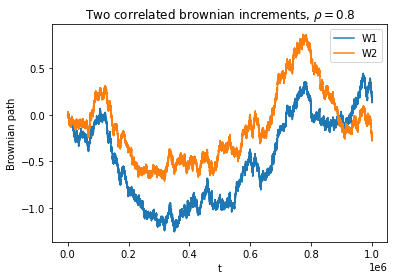

In [19]:
# Two correlated brownian motions
# If dW1 = sqrt(dt)*Z
#    dW2 = p dW1 + sqrt(1-p^2)Z
#                              ... and dZ_t \sim N(0,sqrt(dt))
#https://quant.stackexchange.com/questions/24472/two-correlated-brownian-motions

N = 1000000
T = 1
dt = T/N 
rho = 0.8
dW1 = np.random.normal(0, np.sqrt(dt), N)
dW2 = rho * dW1 + np.sqrt(1 - rho **2) * np.random.normal(0, np.sqrt(dt), N)
W1 = np.cumsum(dW1)
W2 = np.cumsum(dW2)
plt.plot(W1, label = 'W1')
plt.plot(W2, label='W2')
plt.title('Two correlated brownian increments, $\\rho =$'+str(rho))
plt.xlabel('t'); plt.ylabel('Brownian path')
plt.legend(loc=0)
plt.show()

## SABR Model



The Stochastic Alpha Beta Rho (SABR) model is built on the following SDEs:
$$
dX_t = \sigma_t X_t^\beta dW_t^{(1)} \\
d\sigma_t = \alpha \sigma_t dW_t^{(2)}
$$
and,
$$
\mathbb{E}[dW_t^{(1)}dW_t^{(2)}]=\rho dt
$$
Thus, $W_t^{(1)}$ and $W_t^{(2)}$ are two correlated Wiener processes that are related by the correlation coefficient $\rho(X,sigma)$, which defines the relationship between the two processes as 
$$
W_2 = \rho W_1 + \sqrt{1-\rho^2} Z
$$
where $Z\sim N(0,1)$. It is important here that $X_t$ is a martingale and to ensure this, we must have that $\beta \lt 1$. If $\beta = 1$, X_t is only a martinglae for $\rho \lt 0$, otherwise it is not a martingale. 
As this is a complex model Monte Carlo is often used to numerically simulate the system.
In order to assure that our $\sigma$ is positive we rewrite the dynamics in terms of $S=\log \sigma$ to achieve:
$$
dX_t = e^{X_t}X_t^\beta dW_t^{(1)} \\
dS_t = -\frac{1}{2}\alpha^2 dt + \alpha dW_t^{(2)}
$$

This then further leads to a log-Euler scheme such that
$$
X_{t+1} = \big( X_t + \sigma_t X_t^\beta \Delta W_t^{(1)}  \big)^+ \\
\sigma_{t+1} = \sigma_t e^{\alpha \Delta W_t^{(2)} - \frac{\Delta t \alpha^2}{2}}
$$
where $(\circ)^+ = max(0, \circ)$ such that there is an absorbing boundary at X=0, and $\Delta W_t^{(1)},\Delta W_t^{(2)}\sim N(0,\Delta t)$, and $\Delta W_t^{(1)}, \Delta W_t^{(2)}$ are correlated by $\rho$. 